In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import wordcloud
import imblearn

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
m_train = pd.read_csv('C:/Users/User/Desktop/Jupyter/CUAI/5월_IMC/IMC_May_train.csv')
m_test = pd.read_csv('C:/Users/User/Desktop/Jupyter/CUAI/5월_IMC/IMC_May_test.csv')

### Check for NaN values

In [3]:
m_train.info() # no NAN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Message_body  975 non-null    object
 1   Label         975 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


In [4]:
m_train.Label.unique().tolist()

['Non-Spam', 'Spam']

### Imbalanced Data  
we can see that this data set has duplicates and is a imbalanced data set.

In [5]:
m_train.groupby('Label').describe()

Message_body         \
                count unique   
Label                          
Non-Spam          812    802   
Spam              163    159   

                                                                  
                                                        top freq  
Label                                                             
Non-Spam                             Sorry, I'll call later    4  
Spam      December only! Had your mobile 11mths+? You ar...    2

<AxesSubplot:xlabel='Label', ylabel='count'>

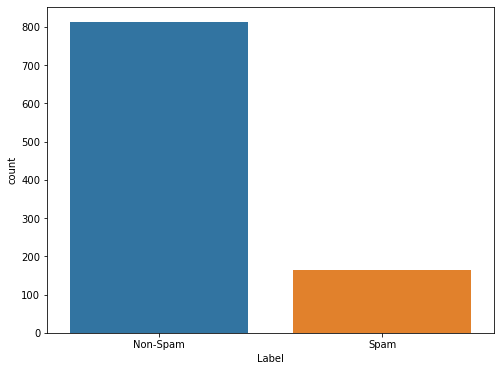

In [6]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(m_train.Label)

In [7]:
per = (len(m_train[m_train.Label =='Spam'])/len(m_train[m_train.Label =='Non-Spam']))*100
print('Percentage of spam messages : {}%'.format(per))

Percentage of spam messages : 20.073891625615765%


### Check for Duplicates & Drop Duplicates & Reset Index

In [8]:
m_train.duplicated().sum()

14

In [9]:
m_train.drop_duplicates(keep='first', inplace=True)

In [10]:
m_train.reset_index(drop=True, inplace=True)

### Visualize using WordCloud

In [11]:
# Get all the ham and spam emails
ham = m_train[m_train.Label =='Non-Spam']
spam = m_train[m_train.Label == 'Spam']
# Create numpy list to visualize using wordcloud
ham_text = " ".join(ham.Message_body.to_numpy().tolist())
spam_text = " ".join(spam.Message_body.to_numpy().tolist())

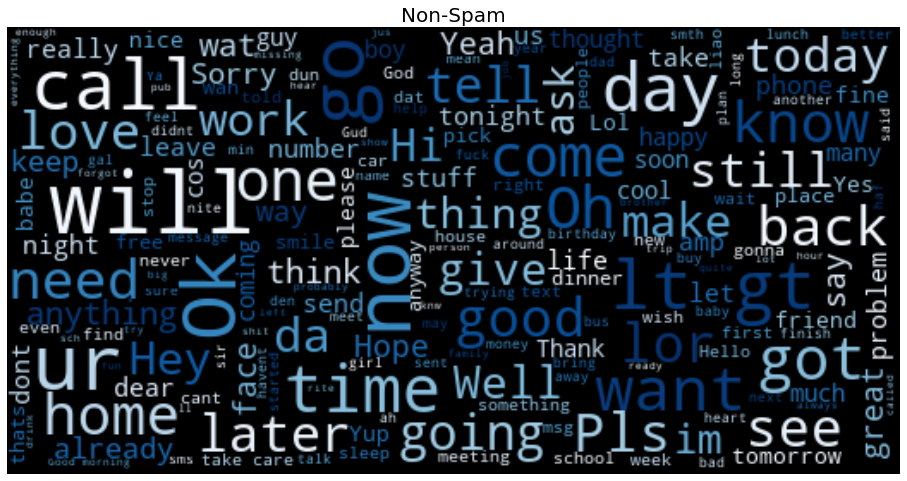

In [12]:
ham_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.title("Non-Spam", fontsize=20)
plt.show()

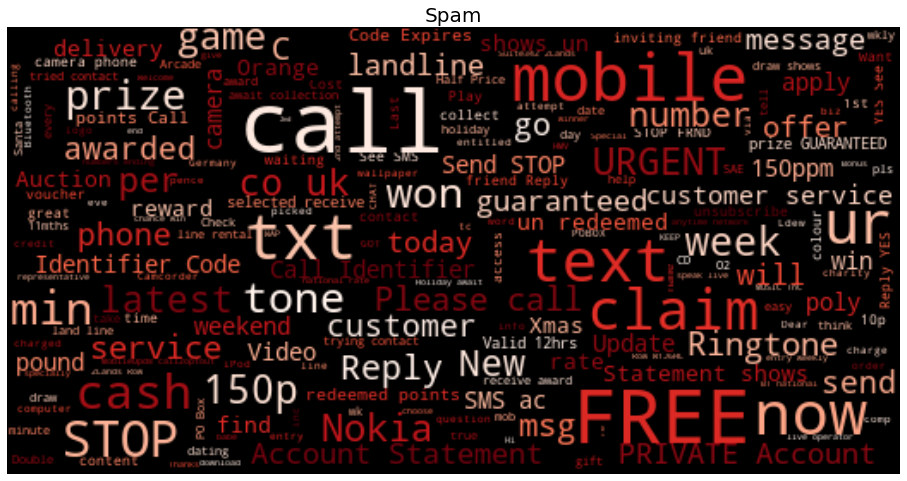

In [13]:
# wordcloud of spam messages
spam_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Reds').generate(spam_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Spam", fontsize=20)
plt.show()

### Make a Copy of the dataset

In [14]:
m_train2 = m_train.copy()

### Length of Message

In [15]:
m_train2['Message_body_len'] = m_train2.Message_body.apply(len)
m_train2.head()

,Message_body,Label,Message_body_len
0,Rofl. Its true to its name,Non-Spam,26
1,The guy did some bitching but I acted like i'd...,Non-Spam,125
2,"Pity, * was in mood for that. So...any other s...",Non-Spam,57
3,Will ?b going to esplanade fr home?,Non-Spam,35
4,This is the 2nd time we have tried 2 contact u...,Spam,159


Text(0.5, 0, 'Length')

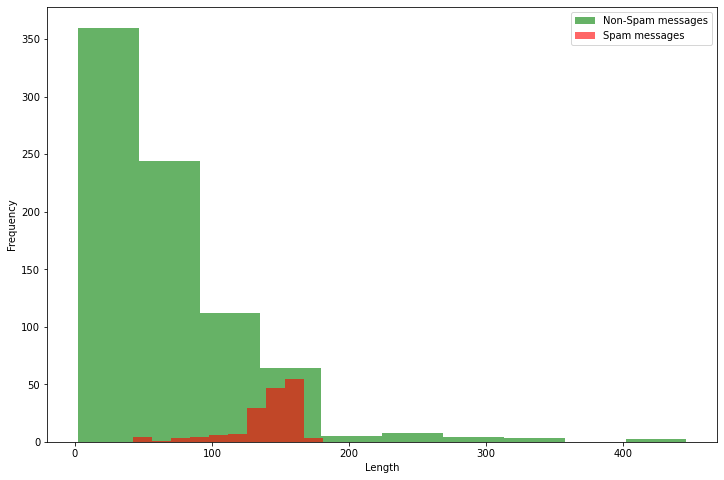

In [16]:
plt.figure(figsize=(12, 8))
m_train2[m_train2.Label=='Non-Spam'].Message_body_len.plot(kind='hist', color='green', 
                                       label='Non-Spam messages', alpha=0.6)
m_train2[m_train2.Label=='Spam'].Message_body_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Length")

We can see that Spam messages tend to have more words than Non-Spam messages

### Do Spam messages have more numbers?

In [17]:
m_train2['number'] = m_train2["Message_body"].str.replace(r"\D", "")

In [18]:
for i in range(len(m_train2)):
    m_train2['number'][i] = len(m_train2['number'][i])

In [19]:
len(m_train2)

961

In [20]:
m_train2.head(20)

,Message_body,Label,Message_body_len,number
0,Rofl. Its true to its name,Non-Spam,26,0
1,The guy did some bitching but I acted like i'd...,Non-Spam,125,0
2,"Pity, * was in mood for that. So...any other s...",Non-Spam,57,0
3,Will ?b going to esplanade fr home?,Non-Spam,35,0
4,This is the 2nd time we have tried 2 contact u...,Spam,159,20
5,REMINDER FROM O2: To get 2.50 pounds free call...,Spam,147,5
6,Huh y lei...,Non-Spam,12,0
7,Why don't you wait 'til at least wednesday to ...,Non-Spam,67,0
8,Ard 6 like dat lor.,Non-Spam,19,1
9,Ok lor... Sony ericsson salesman... I ask shuh...,Non-Spam,96,1


In [21]:
count_ham = 0
for i in range(len(m_train2)):
    if (m_train2['Label'][i] == 'Non-Spam'):
        if m_train2['number'][i] > 0:
            count_ham += 1
print('Number of Non-Spam messages that have numbers inside : {}'.format(count_ham))

Number of Non-Spam messages that have numbers inside : 131


In [22]:
count_spam = 0
for i in range(len(m_train2)):
    if (m_train2['Label'][i] == 'Spam'):
        if int(m_train2['number'][i]) > 0:
            count_spam += 1
print('Number of Spam messages that have numbers inside : {}'.format(count_spam))

Number of Spam messages that have numbers inside : 151


Out of **802** Non-Spam messages **131** of them had numbers.  
While Out of **159** Spam messages **151** of them had numbers!! 

Also if we check if the messages had over 10 numbers in them  
we can see that Only **1** Non-Spam message has more than 10 numbers  
and 121 Spam messages had more than 10 numbers  
So we can say that Spam messages tend to have more numbers than Non-Spam messages

### One-Hot Encode the Labels - (Non-Spam = 0, Spam = 1)

In [23]:
m_train['Label'] = m_train['Label'].map({'Non-Spam':0, 'Spam':1})

0    802
1    159
Name: Label, dtype: int64


<AxesSubplot:>

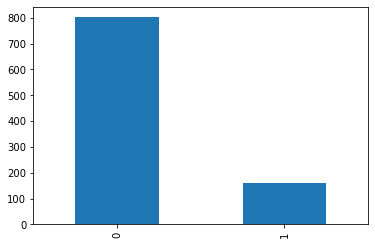

In [24]:
print(m_train['Label'].value_counts())
m_train['Label'].value_counts().plot(kind='bar')

### Seperate data and labels

In [25]:
train_labels = m_train['Label']
train_data = m_train.drop(['Label'], axis=1)
test = m_test
full_data = pd.concat([train_data, test]).reset_index(drop=True)
full_data.shape

(1068, 1)

In [26]:
train_labels

0      0
1      0
2      0
3      0
4      1
      ..
956    1
957    1
958    1
959    1
960    1
Name: Label, Length: 961, dtype: int64

In [27]:
full_data

,Message_body
0,Rofl. Its true to its name
1,The guy did some bitching but I acted like i'd...
2,"Pity, * was in mood for that. So...any other s..."
3,Will ?b going to esplanade fr home?
4,This is the 2nd time we have tried 2 contact u...
...,...
1063,hows my favourite person today? r u workin har...
1064,How much you got for cleaning
1065,Sorry da. I gone mad so many pending works wha...
1066,Wat time ?finish?


### Apply Length to Full Data

In [28]:
#full_data['Message_body_len'] = full_data.Message_body.apply(len)

In [29]:
#full_data.tail()

### Find numbers in messages

In [30]:
#full_data['number'] = full_data["Message_body"].str.replace(r"\D", "")

In [31]:
#for i in range(len(full_data)):
#    full_data['number'][i] = len(full_data['number'][i])

In [32]:
#full_data['number'] = full_data.number.astype(int)

In [33]:
#full_data.dtypes

### Text Preprocessing

In [34]:
import string
import nltk
nltk.download("stopwords")
from string import punctuation
from nltk.corpus import stopwords

def text_processing(message):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    Stopwords = stopwords.words('english')
# Check characters to see if they are in punctuation
    no_punctuation = [char for char in message if char not in string.punctuation]
# Join the characters again to form the string
    no_punctuation = ''.join(no_punctuation)
    
# Now just remove any stopwords
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in Stopwords])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
full_data['Message_process'] = full_data['Message_body'].apply(text_processing)

In [36]:
full_data

,Message_body,Message_process
0,Rofl. Its true to its name,Rofl true name
1,The guy did some bitching but I acted like i'd...,guy bitching acted like id interested buying s...
2,"Pity, * was in mood for that. So...any other s...",Pity mood Soany suggestions
3,Will ?b going to esplanade fr home?,b going esplanade fr home
4,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u U 50 Pound prize 2 ...
...,...,...
1063,hows my favourite person today? r u workin har...,hows favourite person today r u workin hard co...
1064,How much you got for cleaning,much got cleaning
1065,Sorry da. I gone mad so many pending works wha...,Sorry da gone mad many pending works
1066,Wat time ?finish?,Wat time finish


### Tokenize

Hyper-parameters used in Tokenizer object are: num_words and oov_token, char_level.


num_words: Indicate how many unique words to load in training and testing data. For our purpose, we selected 500 words (vocab_size)


oov_token: When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls (see below).


char_level: If it is “True” then every character will be treated as a token. We set it as “False”, hence every word will be treated as a token.

In [37]:
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(full_data['Message_process'])
sequences = tokenizer.texts_to_sequences(full_data['Message_process']) # 단어를 숫자값, 인덱스로 변환하여 저장

In [38]:
sequences[:5]

[[1289, 250, 144],
 [251, 1290, 770, 10, 190, 596, 446, 108, 252, 81, 37, 447, 82, 8],
 [1291, 1292, 1293, 1294],
 [115, 38, 771, 1295, 31],
 [221,
  15,
  253,
  3,
  62,
  1,
  1,
  63,
  772,
  46,
  3,
  26,
  222,
  2,
  1296,
  1297,
  448,
  145,
  449,
  773]]

### Word Index

In [39]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'u': 1,
 'call': 2,
 '2': 3,
 'im': 4,
 'ur': 5,
 'get': 6,
 '4': 7,
 'free': 8,
 'go': 9,
 'like': 10,
 'dont': 11,
 'ok': 12,
 'ltgt': 13,
 'txt': 14,
 'time': 15,
 'text': 16,
 'know': 17,
 'stop': 18,
 'mobile': 19,
 'see': 20,
 'got': 21,
 'good': 22,
 'want': 23,
 'day': 24,
 'come': 25,
 'claim': 26,
 'send': 27,
 'oh': 28,
 'back': 29,
 'one': 30,
 'home': 31,
 'reply': 32,
 'ill': 33,
 'tell': 34,
 'love': 35,
 'need': 36,
 'week': 37,
 'going': 38,
 'r': 39,
 'new': 40,
 '000': 41,
 'later': 42,
 'da': 43,
 'please': 44,
 'phone': 45,
 'prize': 46,
 'pls': 47,
 'still': 48,
 'lor': 49,
 'hey': 50,
 'take': 51,
 'today': 52,
 'well': 53,
 'cash': 54,
 'think': 55,
 'number': 56,
 'give': 57,
 'great': 58,
 'hi': 59,
 'make': 60,
 'n': 61,
 'contact': 62,
 '50': 63,
 'thats': 64,
 'customer': 65,
 'sorry': 66,
 'dear': 67,
 'cant': 68,
 'work': 69,
 'night': 70,
 'hope': 71,
 'last': 72,
 'didnt': 73,
 '1': 74,
 'ask': 75,
 'anything': 76,
 'keep': 77,
 '00': 78,
 'tonight': 7

In [40]:
threshold = 2
total_cnt = len(word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 2299
단어 집합(vocabulary)에서 희귀 단어의 비율: 64.09255645386116
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 22.048527860362523


In [41]:
vocab_size = len(word_index)
print('There are %s unique tokens in training data. ' % vocab_size)

There are 3587 unique tokens in training data. 


In [42]:
print('메일의 최대 길이 : {}'.format(max(len(l) for l in sequences)))

메일의 최대 길이 : 66


In [43]:
trunc_type = "post" 
padding_type = "post"
max_len = 66

In [44]:
data = pad_sequences(sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
data.shape

(1068, 66)

In [45]:
data

array([[1289,  250,  144, ...,    0,    0,    0],
       [ 251, 1290,  770, ...,    0,    0,    0],
       [1291, 1292, 1293, ...,    0,    0,    0],
       ...,
       [  66,   43,  681, ...,    0,    0,    0],
       [  86,   15,  186, ...,    0,    0,    0],
       [ 720,  570,    0, ...,    0,    0,    0]])

### Train & Test

In [46]:
#data1 = full_data.drop(['Message_body', 'Message_process'],axis=1)
#data2 = pd.DataFrame(data)
#preprocessed_data = pd.concat([data1, data2], axis=1).reset_index(drop=True)

In [47]:
preprocessed_data = pd.DataFrame(data)

In [48]:
x_train = preprocessed_data[:len(m_train)]

y_label = np.array(train_labels)

x_test = preprocessed_data[len(m_train):]

In [49]:
x_test.shape

(107, 66)

In [50]:
print(x_train.shape)
print(y_label.shape)

(961, 66)
(961,)


### Train-test Split

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_label, test_size=0.3, random_state=44)

### SMOTE

use the SMOTE algorithm to balance the unbalanced data set.

In [52]:
#smote = SMOTE(random_state=44)

# Using Smote to Generate synthetic data
#x_smote, y_smote = smote.fit_resample(x_train, y_label)
#x_smote.shape

In [53]:
#x_smote

### TF Model1

In [54]:
import tensorflow as tf
import os
tf.keras.backend.clear_session()
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [55]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.5))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          114784    
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [57]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('tensorflowNL.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x=X_train, y=y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[es, mc])

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 0.6487 - acc: 0.7132
Epoch 00001: val_acc improved from -inf to 0.82222, saving model to tensorflowNL.h5
17/17 [==============================] - 0s 14ms/step - loss: 0.6487 - acc: 0.7132 - val_loss: 0.6189 - val_acc: 0.8222
Epoch 2/20
 1/17 [>.............................] - ETA: 0s - loss: 0.5689 - acc: 0.8125
Epoch 00002: val_acc did not improve from 0.82222
17/17 [==============================] - 0s 4ms/step - loss: 0.4999 - acc: 0.8380 - val_loss: 0.4942 - val_acc: 0.8222
Epoch 3/20
 1/17 [>.............................] - ETA: 0s - loss: 0.4346 - acc: 0.8438
Epoch 00003: val_acc did not improve from 0.82222
17/17 [==============================] - 0s 3ms/step - loss: 0.4521 - acc: 0.8380 - val_loss: 0.4700 - val_acc: 0.8222
Epoch 4/20
 1/17 [>.............................] - ETA: 0s - loss: 0.3400 - acc: 0.9062
Epoch 00004: val_acc did not improve from 0.82222
17/17 [==============================] - 0s 4ms/step

In [59]:
model.evaluate(X_valid, y_valid)

10/10 [==============================] - ETA: 0s - loss: 0.0477 - acc: 0.968 - 0s 2ms/step - loss: 0.0653 - acc: 0.9827


[0.06532307714223862, 0.9826989769935608]

In [60]:
predictions = model.predict(x_test, batch_size=32)

In [61]:
predictions[0]

array([0.9316305], dtype=float32)

In [62]:
np.round(predictions[0])

array([1.], dtype=float32)

In [63]:
np.round(predictions).reshape(107)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.], dtype=float32)

In [64]:
submission = np.round(predictions).reshape(107).astype(np.int)

In [65]:
MK = pd.DataFrame({'prediction':submission})

In [66]:
MK

,labels
0,1
1,1
2,1
3,1
4,1
...,...
102,0
103,0
104,0
105,0


In [67]:
MK.to_csv('김민구_Adv_result.csv',index=False)